### Land mine classifier

Author: Taha Parsayan
Date: 2025 Jan 07

Make a vertual environment

python -m venv packages

Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass

.\packages\Scripts\Activate.ps1

python.exe -m pip install --upgrade pip
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/

In [1]:
# Importing Libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import shutil
import glob
import Land_mine_data_management_functions as dmf
from PIL import Image
from torch.utils.data import DataLoader
from going_modular import data_setup, engine, model_builder, predictions
import random
from pathlib import Path
from torchinfo import summary
import torch.multiprocessing as mp
from helper_functions import plot_loss_curves
from torchvision.transforms.functional import InterpolationMode


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Using device:', device)


e:\Python-codes\Pytorch\packages\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### Inspect the existing data

In [2]:
current_path = os.getcwd()
folder_path = 'DatainBrief_dataset_1'
folder_path = os.path.join(current_path, folder_path)

def walk_through_directory(path):
    for root, dirs, files in os.walk(path):
        print(f"Root folder: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {files}")
        print("-" * 40)

data_path = os.path.join(current_path, 'data')
walk_through_directory(data_path)

Root folder: e:\Python-codes\Pytorch\data
Subdirectories: ['FashionMNIST', 'land_mine', 'pizza_steak_sushi', 'test', 'train']
Files: ['pizza_steak_sushi.zip']
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\FashionMNIST
Subdirectories: ['raw']
Files: []
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\FashionMNIST\raw
Subdirectories: []
Files: ['t10k-images-idx3-ubyte', 't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte', 't10k-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte', 'train-labels-idx1-ubyte.gz']
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\land_mine
Subdirectories: ['test', 'train']
Files: []
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\land_mine\test
Subdirectories: ['Free zone', 'Mine 10 cm depth', 'Mine 1cm depth', 'Mine 5cm depth', 'Surface Mine 0cm depth']
Files: []
---

### Prepare the data

There are 5 folders containing images of landmines. 
We take 4 of them for training and 1 for testing.

In [3]:

# Names of the landmine types
landmine_types = [
    "Mine 1cm depth",
    "Surface Mine 0cm depth",
    "Free zone",
    "Mine 5cm depth",
    "Mine 10 cm depth"
]

# Names of image acquisition dates
train_date_folders = [
    "03_03_2020",
    "13_02_2020",
    "17_02_2020",
    "20_02_2020"
]

test_date_folders = [
    "24_02_2020"
]

# Define the path for the 'data' folder
all_data_path = os.path.join(current_path, 'data', 'land_mine')
train_data_path = os.path.join(current_path, 'data','land_mine', 'train')
test_data_path = os.path.join(current_path, 'data','land_mine', 'test')

# dmf.create_landmine_folders(train_data_path, landmine_types)
# dmf.copy_images_to_landmine_folders(folder_path, train_data_path, landmine_types, train_date_folders)

# dmf.create_landmine_folders(test_data_path, landmine_types)
# dmf.copy_images_to_landmine_folders(folder_path, test_data_path, landmine_types, test_date_folders)


### See the data
Show one random image from the data

Number of training images: 465
Number of testing images: 126
Random image path: e:\Python-codes\Pytorch\data\land_mine\train\Mine 5cm depth\17_02_2020_25.jpg
Image class: Mine 5cm depth
Image height: 480
Image width: 720
Image mode: RGB
Image format: JPEG


(-0.5, 719.5, 479.5, -0.5)

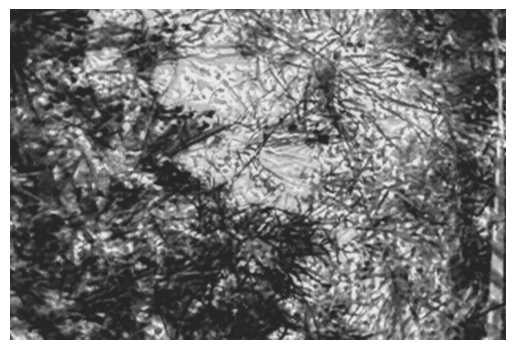

In [4]:
random.seed(42)

all_data_path = Path(all_data_path)
train_data_path = Path(train_data_path)
test_data_path = Path(test_data_path)

train_image_path_list = list(train_data_path.glob("*/*.jpg"))
test_image_path_list = list(test_data_path.glob("*/*.jpg"))

print(f"Number of training images: {len(train_image_path_list)}")
print(f"Number of testing images: {len(test_image_path_list)}")

random_image_path = random.choice(train_image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
print(f"Image mode: {img.mode}")
print(f"Image format: {img.format}")

plt.imshow(img)
plt.axis('off')

### Classification model
ViT classification model
Through transfer learning, we freeze the rest of the data and keep the head layer learnable.

In [35]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Transfer learning
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)
# # Modify the first convolution layer to accept 1-channel (grayscale) input
# pretrained_vit.conv_proj = nn.Conv2d(
#     in_channels=3,  # Grayscale image (1 channel)
#     out_channels=768,  # Output channels
#     kernel_size=16,  # Same kernel size
#     stride=16  # Same stride
# ).to(device)

pretrained_vit.heads = nn.Linear(
    in_features=768, 
    out_features=5
).to(device)

# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(4, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [4, 3, 224, 224]     [4, 5]               768                  Partial
├─Conv2d (conv_proj)                                         [4, 3, 224, 224]     [4, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [4, 197, 768]        [4, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [4, 197, 768]        [4, 197, 768]        --                   --
│    └─Sequential (layers)                                   [4, 197, 768]        [4, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [4, 197, 768]        [4, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [4, 197, 768]        [4, 1

### Dataloader
Prepare the data for training and testing

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
 
['Free zone', 'Mine 10 cm depth', 'Mine 1cm depth', 'Mine 5cm depth', 'Surface Mine 0cm depth']
Number of classes: 5
 
Numer of training data:  960
Numer of testing data:  256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5424266..2.0822659].


torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([3, 224, 224]) tensor(2)


(-0.5, 223.5, 223.5, -0.5)

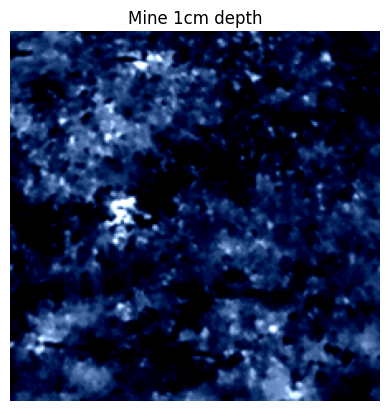

In [37]:
from going_modular.data_setup import create_dataloaders
# Main dataset
batch_size = 32
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_data_path,
                                                                                                     test_dir=test_data_path,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size = batch_size)

# Augmentaed dataset to be added to the main dataset

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # Random horizontal flip
    transforms.RandomRotation(degrees=15, interpolation=InterpolationMode.BICUBIC),   # Random rotation
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip
    transforms.Resize(size=[256], interpolation=InterpolationMode.BILINEAR),  # Resize to 256
    transforms.CenterCrop(size=[224]),  # Center crop to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(
        mean=pretrained_vit_weights.transforms().mean,
        std=pretrained_vit_weights.transforms().std
    )
])

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_data_path, 
    test_dir=test_data_path,
    transform=pretrained_vit_transforms,
    batch_size=batch_size,
    augmentation_transform=augmentation_transform
)


print(' ')
print(class_names)
print(f"Number of classes: {len(class_names)}")

print(' ')
print("Numer of training data: ", len(train_dataloader_pretrained) * batch_size)
print("Numer of testing data: ", len(test_dataloader_pretrained) * batch_size)

# image_batch, label_batch = next(iter(train_dataloader_pretrained))
# print(image_batch.shape, label_batch.shape)

# image, label = image_batch[0], label_batch[0]
# print(image.shape, label)

# plt.imshow(image.permute(1, 2, 0))
# plt.title(class_names[label])
# plt.axis(False)

### Train the model

In [38]:
# Check the device
print(f"Working on device: {device}")

# Create optimizer and loss function
optimizer = optimizer =torch.optim.Adam(params = pretrained_vit.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

Working on device: cuda


 10%|█         | 1/10 [01:30<13:38, 90.93s/it]

Epoch: 1 | train_loss: 0.7104 | train_acc: 0.7344 | test_loss: 1.3121 | test_acc: 0.4816


 20%|██        | 2/10 [03:02<12:11, 91.42s/it]

Epoch: 2 | train_loss: 0.6811 | train_acc: 0.7500 | test_loss: 1.1895 | test_acc: 0.4933


 30%|███       | 3/10 [04:34<10:40, 91.54s/it]

Epoch: 3 | train_loss: 0.6615 | train_acc: 0.7958 | test_loss: 1.2667 | test_acc: 0.4950


 40%|████      | 4/10 [06:07<09:12, 92.02s/it]

Epoch: 4 | train_loss: 0.6213 | train_acc: 0.7937 | test_loss: 1.2413 | test_acc: 0.5184


 50%|█████     | 5/10 [07:38<07:38, 91.69s/it]

Epoch: 5 | train_loss: 0.6205 | train_acc: 0.7896 | test_loss: 1.2222 | test_acc: 0.4805


 60%|██████    | 6/10 [09:10<06:07, 91.81s/it]

Epoch: 6 | train_loss: 0.5668 | train_acc: 0.8344 | test_loss: 1.2294 | test_acc: 0.5095


 70%|███████   | 7/10 [10:41<04:35, 91.76s/it]

Epoch: 7 | train_loss: 0.5380 | train_acc: 0.8313 | test_loss: 1.3058 | test_acc: 0.4738


 70%|███████   | 7/10 [11:12<04:48, 96.12s/it]


KeyboardInterrupt: 

### Plot model performance

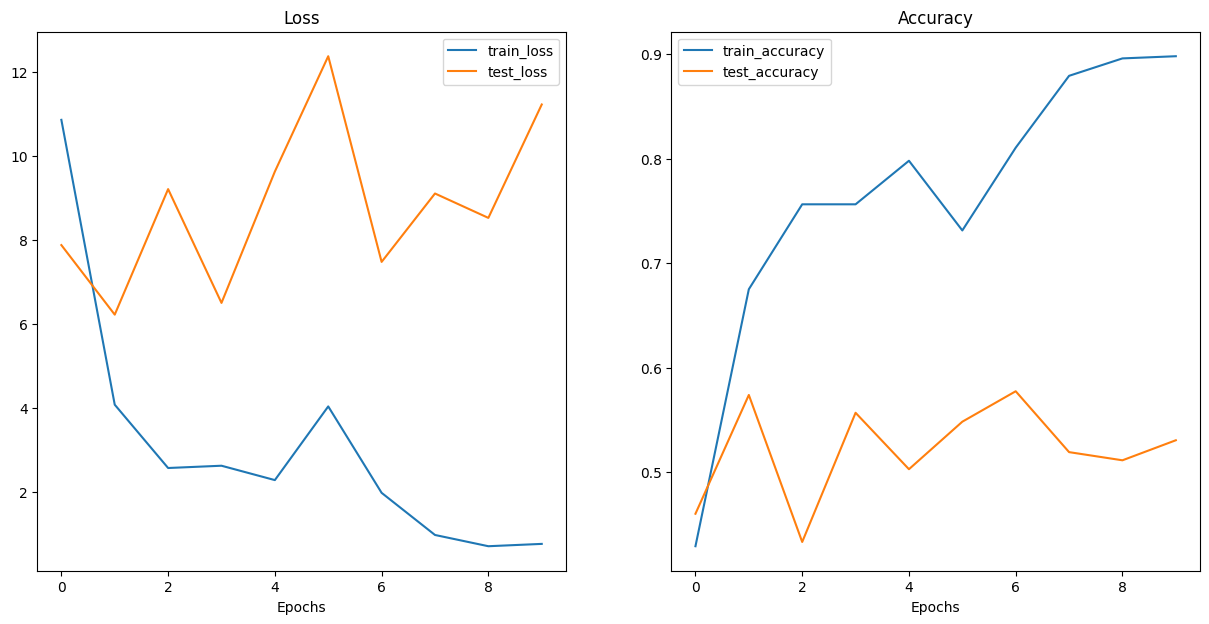

In [23]:
# Plot the loss curves
plot_loss_curves(pretrained_vit_results)